# Documentation for 1A.ipynb

## Introduction
This notebook focuses on data analysis and machine learning for a dataset related to cirrhosis stages. It includes data loading, preprocessing, exploratory data analysis (EDA), and model development using machine learning algorithms.

## 1. Import Required Libraries
The following libraries are imported for data manipulation, visualization, and machine learning:
- `pandas`: For data manipulation and analysis.
- `numpy`: For numerical operations.
- `scipy.stats`: For statistical tests.
- `matplotlib.pyplot`: For data visualization.
- `seaborn`: For enhanced data visualization.
- `sklearn`: For machine learning algorithms and metrics.
- `xgboost`: For the XGBoost classifier.

In [1]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import math

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

plt.style.use('fivethirtyeight')

## 1.1 Data Loading and Initial Exploration
In this section, the dataset is loaded, and basic information, missing values, and sample data are displayed.

In [2]:
# Load the dataset
df = pd.read_csv("1A.tsv", delimiter='\t')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

Dataset Shape: (418, 18)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   ID                         418 non-null    int64  
 1   Registration Date          418 non-null    object 
 2   Drug                       312 non-null    object 
 3   Birth Date                 418 non-null    object 
 4   Gender                     418 non-null    object 
 5   Ascites                    312 non-null    object 
 6   Hepatomegaly               312 non-null    object 
 7   Edema                      418 non-null    object 
 8   Bilirubin                  418 non-null    float64
 9   Cholesterol                80 non-null     float64
 10  Albumin                    418 non-null    float64
 11  Copper                     310 non-null    float64
 12  Alkaline Phospatase (U/L)  312 non-null    float64
 13  SGOT      

In [3]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values[missing_values > 0])

# Display sample data
print("\nSample Data:")
df.head()


Missing Values:
Drug                         106
Ascites                      106
Hepatomegaly                 106
Cholesterol                  338
Copper                       108
Alkaline Phospatase (U/L)    106
SGOT                         106
Platelets                     11
Prothrombin                    2
Stage                          6
dtype: int64

Sample Data:


,ID,Registration Date,Drug,Birth Date,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,2023/11/07,D-penicillamine,1966/03/07,F,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,Stage4
1,2,2012/08/16,D-penicillamine,1968/07/01,F,N,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,stage_3
2,3,2022/03/05,D-penicillamine,1954/11/15,M,N,N,S,1.4,NaN,3.48,210.0,516.0,96.10,55.0,151.0,12.0,Stage4
3,4,2019/09/04,D-penicillamine,1970/03/16,F,N,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,Stage4
4,5,2020/10/29,Placebo,1986/11/03,F,N,Y,N,3.4,NaN,3.53,143.0,671.0,113.15,72.0,136.0,10.9,stage_3


We have several missing values

In [4]:
# Identify numerical and categorical columns
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"\nNumerical columns: {num_cols}")
print(f"Categorical columns: {cat_cols}")


Numerical columns: ['ID', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alkaline Phospatase (U/L)', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
Categorical columns: ['Registration Date', 'Drug', 'Birth Date', 'Gender', 'Ascites', 'Hepatomegaly', 'Edema', 'Stage']


## 2. Preprocess
This section handles missing values and transforms features. The 'ID' column is dropped as it does not impact the analysis.

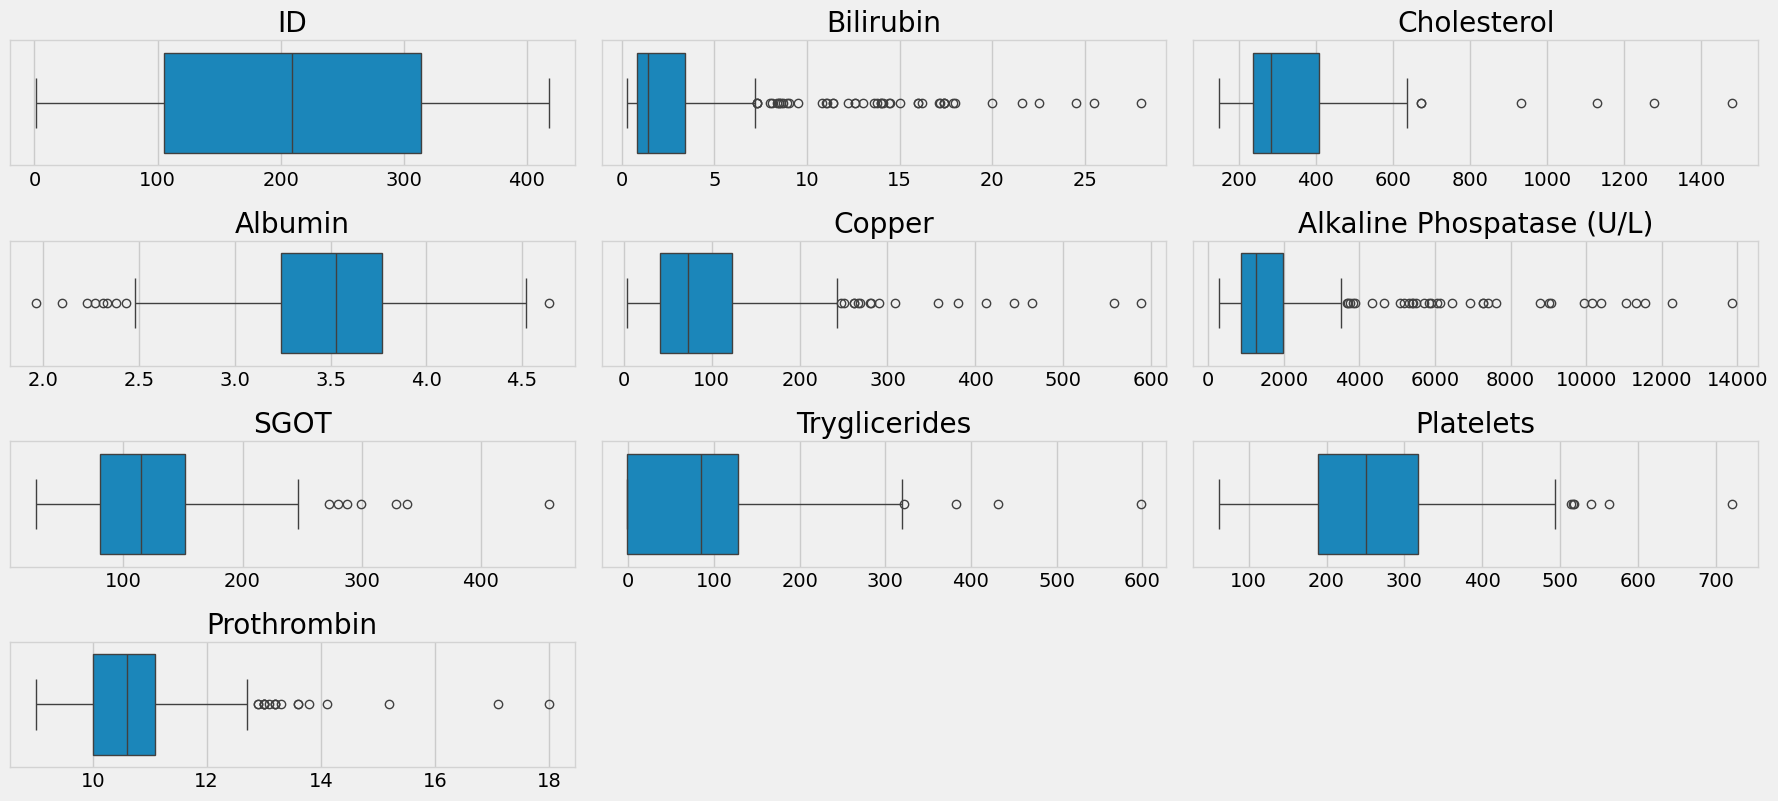

In [5]:
plt.figure(figsize=(18, 10))

# Adjust the number of rows and columns in the subplot
n_rows = 5
n_cols = 3

for i, col in enumerate(num_cols, 1):
    ax = plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=df[col], ax=ax)
    plt.title(col)
    plt.xlabel("")
    
    # Add border to the current subplot
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgrey')
        spine.set_linewidth(1)

plt.tight_layout() 
plt.show()


In [6]:
# Drop id since it doesn't really add any impact
df.drop('ID', axis= 1, inplace = True)

# Handling missing value
# There is too many missing values in Cholesterol so I decided to just drop it to not cause a noise in the data
df.drop('Cholesterol', axis= 1, inplace = True)

# Checking target missing value
df[df['Stage'].isnull()]

,Registration Date,Drug,Birth Date,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage
312,2013/10/28,NaN,1964/12/11,F,NaN,NaN,N,0.7,3.65,NaN,NaN,NaN,-1.0,378.0,11.0,NaN
316,2016/08/25,NaN,1962/12/11,F,NaN,NaN,N,0.8,2.48,NaN,NaN,NaN,-1.0,273.0,10.0,NaN
318,2024/10/31,NaN,1978/12/11,F,NaN,NaN,N,5.0,2.93,NaN,NaN,NaN,-1.0,260.0,10.4,NaN
321,2019/06/10,NaN,1960/12/11,F,NaN,NaN,N,1.1,3.69,NaN,NaN,NaN,-1.0,139.0,10.5,NaN
333,2023/09/02,NaN,1968/12/11,F,NaN,NaN,N,7.1,3.51,NaN,NaN,NaN,-1.0,721.0,11.8,NaN
336,2018/09/08,NaN,1968/12/11,F,NaN,NaN,N,1.8,3.64,NaN,NaN,NaN,-1.0,141.0,10.0,NaN


In [7]:
# Turns out column stage is missing when most of other column are missing, so we just drop it
df = df.dropna(subset=['Stage'])

df.loc[df['Tryglicerides'] < 0]

,Registration Date,Drug,Birth Date,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage
13,2021/08/12,Placebo,1968/09/21,M,Y,Y,Y,0.8,2.27,43.0,728.0,71.00,-1.0,156.0,11.0,Stage4
39,2012/09/18,D-penicillamine,1978/04/11,F,N,N,N,1.3,3.34,105.0,11046.6,104.49,-1.0,358.0,11.0,Stage4
40,2021/04/01,D-penicillamine,1991/04/24,F,N,Y,N,6.8,3.26,96.0,1215.0,151.90,-1.0,226.0,11.7,Stage4
41,2012/10/02,Placebo,1991/04/02,F,N,Y,N,2.1,3.54,122.0,8778.0,56.76,-1.0,344.0,11.0,Stage4
44,2013/12/04,Placebo,1983/02/25,F,N,N,N,0.6,3.93,19.0,1826.0,71.30,-1.0,474.0,10.9,Stage 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,2023/01/30,NaN,1957/12/11,F,NaN,NaN,N,1.2,2.96,NaN,NaN,NaN,-1.0,174.0,10.9,stage_3
414,2021/12/04,NaN,1985/12/11,F,NaN,NaN,N,0.9,3.83,NaN,NaN,NaN,-1.0,180.0,11.2,Stage4
415,2022/01/21,NaN,1967/12/12,F,NaN,NaN,N,1.6,3.42,NaN,NaN,NaN,-1.0,143.0,9.9,stage_3
416,2023/01/20,NaN,1966/12/11,F,NaN,NaN,N,0.8,3.75,NaN,NaN,NaN,-1.0,269.0,10.4,stage_3


In [8]:
# Some column have Tryglicerides lower than 0 which is not possible so i make them null
df.loc[df['Tryglicerides'] < 0, 'Tryglicerides'] = np.nan

In [9]:
# Check for missing values 
missing_values = df.isnull().sum()
print("\nMissing Values:")
print(missing_values[missing_values > 0])


Missing Values:
Drug                         100
Ascites                      100
Hepatomegaly                 100
Copper                       102
Alkaline Phospatase (U/L)    100
SGOT                         100
Tryglicerides                130
Platelets                     11
Prothrombin                    2
dtype: int64


Columns with significant missing values (≥ 20% missing):
- Drug
- Ascites
- Hepatomegaly
- Copper
- Alkaline Phospatase (U/L)
- SGOT
- Tryglicerides (> 30%)

Columns with low missing values (< 5% missing):
- Platelets
- Prothrombin

In [10]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
df_clean = df.dropna(subset=["Copper", "Alkaline Phospatase (U/L)", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"])
df_clean[num_cols].corr()

,Bilirubin,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin
Bilirubin,1.000000,-0.312043,0.460527,0.138787,0.424987,0.439691,-0.074395,0.331176
Albumin,-0.312043,1.000000,-0.240408,-0.111497,-0.198210,-0.109673,0.198600,-0.199584
Copper,0.460527,-0.240408,1.000000,0.190912,0.301858,0.284579,-0.083976,0.213770
Alkaline Phospatase (U/L),0.138787,-0.111497,0.190912,1.000000,0.145242,0.182566,0.147250,0.087784
SGOT,0.424987,-0.198210,0.301858,0.145242,1.000000,0.134957,-0.058951,0.069940
Tryglicerides,0.439691,-0.109673,0.284579,0.182566,0.134957,1.000000,0.101285,0.025087
Platelets,-0.074395,0.198600,-0.083976,0.147250,-0.058951,0.101285,1.000000,-0.192859
Prothrombin,0.331176,-0.199584,0.213770,0.087784,0.069940,0.025087,-0.192859,1.000000


Since there isn't really any correlation within missing data, we just going with the median/mean imputation

In [11]:
# Impute categorical features with mode
cat_missing = ['Drug', 'Ascites', 'Hepatomegaly']
for col in cat_missing:
    df[col] = df[col].fillna(df[col].mode()[0])

# Impute numerical features with median
num_missing = ['Copper', 'Alkaline Phospatase (U/L)', 'SGOT', 'Platelets', 'Tryglicerides']
for col in num_missing:
    df[col] = df[col].fillna(df[col].median())

In [12]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

for i in cat_cols:
    print(df[i].value_counts(),'\n')

Registration Date
2017/12/05    2
2023/04/24    2
2021/01/07    2
2020/07/11    2
2021/03/19    2
             ..
2016/06/18    1
2016/04/27    1
2016/04/28    1
2017/04/16    1
2022/04/10    1
Name: count, Length: 394, dtype: int64 

Drug
D-penicillamine    255
Placebo            152
d-penicillamine      3
placebo              1
lacebo               1
Name: count, dtype: int64 

Birth Date
1970/12/11    7
1973/12/11    6
1972/12/11    6
1962/12/11    4
1960/12/11    4
             ..
1982/04/22    1
1972/02/13    1
1973/09/17    1
1969/06/27    1
1989/12/11    1
Name: count, Length: 344, dtype: int64 

Gender
F    368
M     44
Name: count, dtype: int64 

Ascites
N    388
Y     24
Name: count, dtype: int64 

Hepatomegaly
Y    260
N    152
Name: count, dtype: int64 

Edema
N    348
S     44
Y     20
Name: count, dtype: int64 

Stage
stage_3    155
Stage4     144
Stage 2     92
Stage 1     21
Name: count, dtype: int64 



In [13]:
# Some error naming in drug column
df.loc[df['Drug'] == 'd-penicillamine', 'Drug'] = 'D-penicillamine'
df.loc[df['Drug'].isin(['placebo', 'lacebo']), 'Drug'] = 'Placebo'

# using 0,1,2,3 since it works better with classifier model
df['Stage'] = df['Stage'].map({'Stage 1': 0, 'Stage 2': 1, 'stage_3': 2, 'Stage4': 3}).astype(int)

# Remove duplicates
df = df.drop_duplicates()
print(f"Dataset shape after removing duplicates: {df.shape}")

num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

Dataset shape after removing duplicates: (412, 16)


Transform Registration to month since Registration

Transform Birthdate to age(in month) when registration happen

In [14]:
# Transforming Registration Date & Birthdate
# Ensure the 'Registration Date' column is in datetime format
df['Registration Date'] = pd.to_datetime(df['Registration Date'])

# Calculate the number of months since the Registration Date
df['Months'] = ((pd.Timestamp.now() - df['Registration Date']).dt.days / 30.44).round(2) # 30.44 is average day in a month
df = df[['Months'] + [col for col in df.columns if col != 'Months']]

# Ensure the 'Birth Date' column is in datetime format
df['Birth Date'] = pd.to_datetime(df['Birth Date'])

# Calculate the number of months since Birth Date from Registration Date
df['Age(months)'] = ((df['Registration Date'] - df['Birth Date']).dt.days / 30.44).round(2) # 30.44 is average day in a month
df = df[['Age(months)'] + [col for col in df.columns if col != 'Age(months)']]

df.drop('Registration Date', axis= 1, inplace = True)
df.drop('Birth Date', axis= 1, inplace = True)

In [15]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

## 3. EDA
Exploratory Data Analysis is performed to visualize the distribution of the data and relationships between features.

C:\Users\Ghazi\AppData\Local\Temp\ipykernel_21272\649463604.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df['Stage'].value_counts().index, rotation=80)


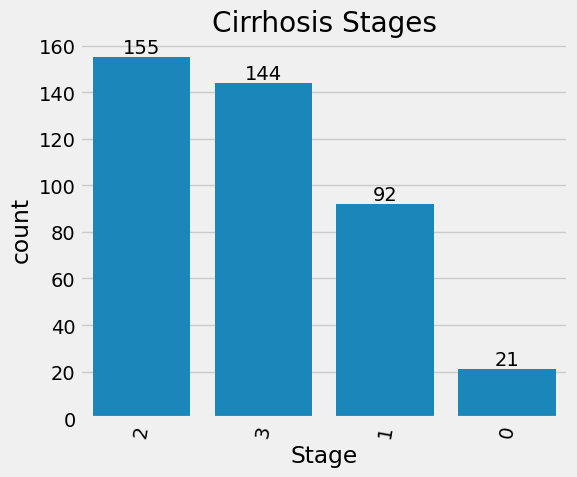

In [16]:
# Create countplot for Cirrhosis Stages
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.countplot(x='Stage', data=df, order=df['Stage'].value_counts().index)
ax.set_xticklabels(df['Stage'].value_counts().index, rotation=80)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Cirrhosis Stages')
plt.tight_layout()  # Ensure layout fits
plt.show()

there are only 21 cirrhosis stage 1 sample, could mean unbalance data

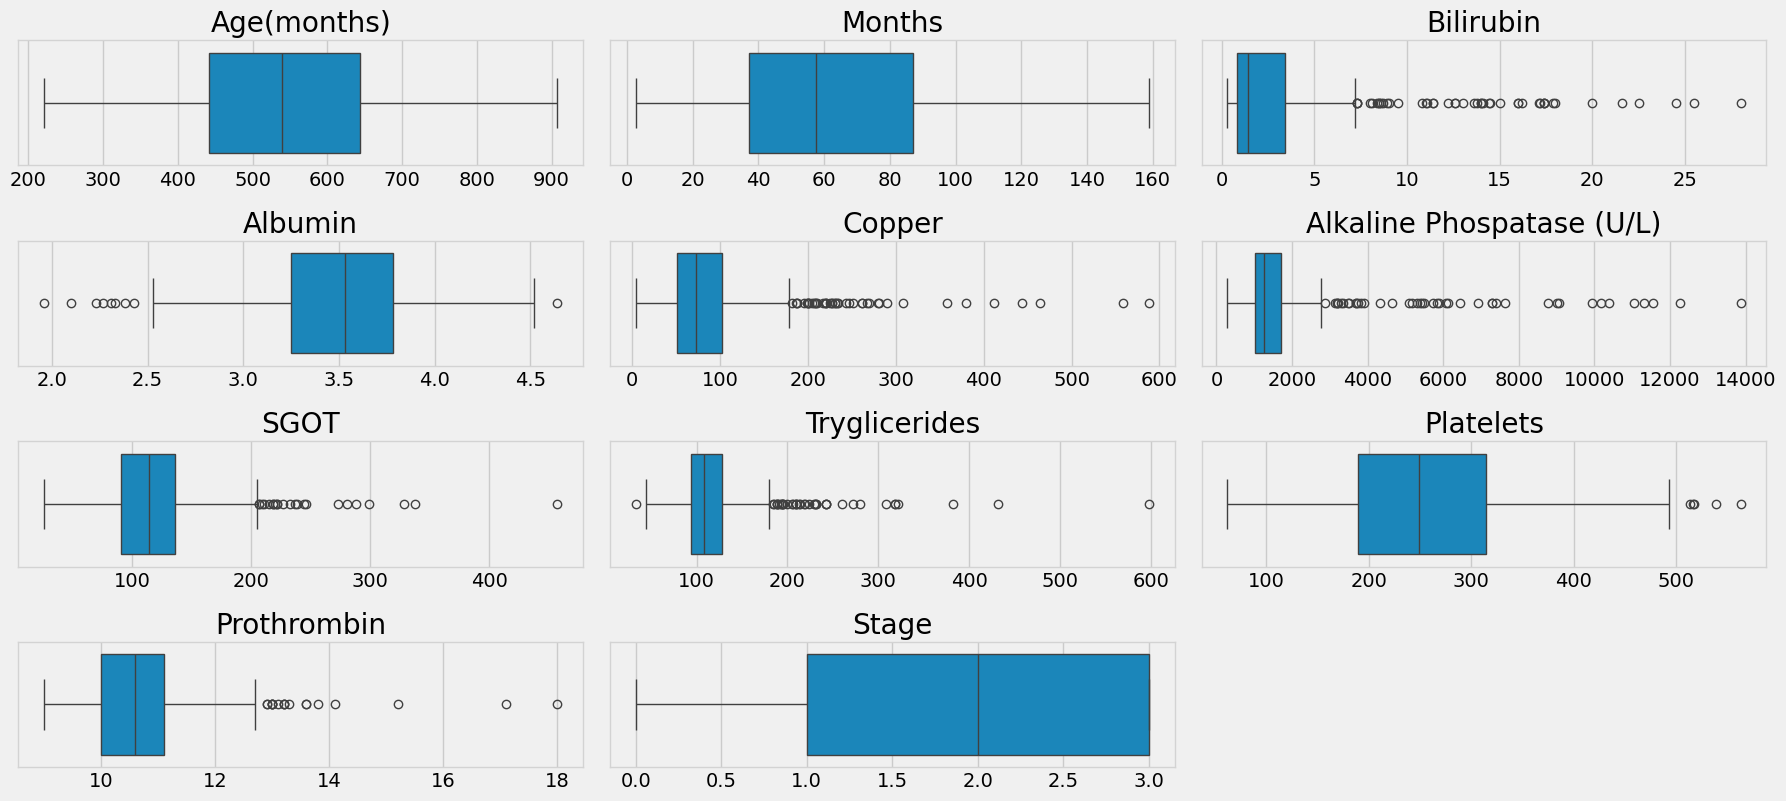

In [17]:
plt.figure(figsize=(18, 10))

# Adjust the number of rows and columns in the subplot
n_rows = 5
n_cols = 3

for i, col in enumerate(num_cols, 1):
    ax = plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=df[col], ax=ax)
    plt.title(col)
    plt.xlabel("")
    
    # Add border to the current subplot
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgrey')
        spine.set_linewidth(1)

plt.tight_layout() 
plt.show()


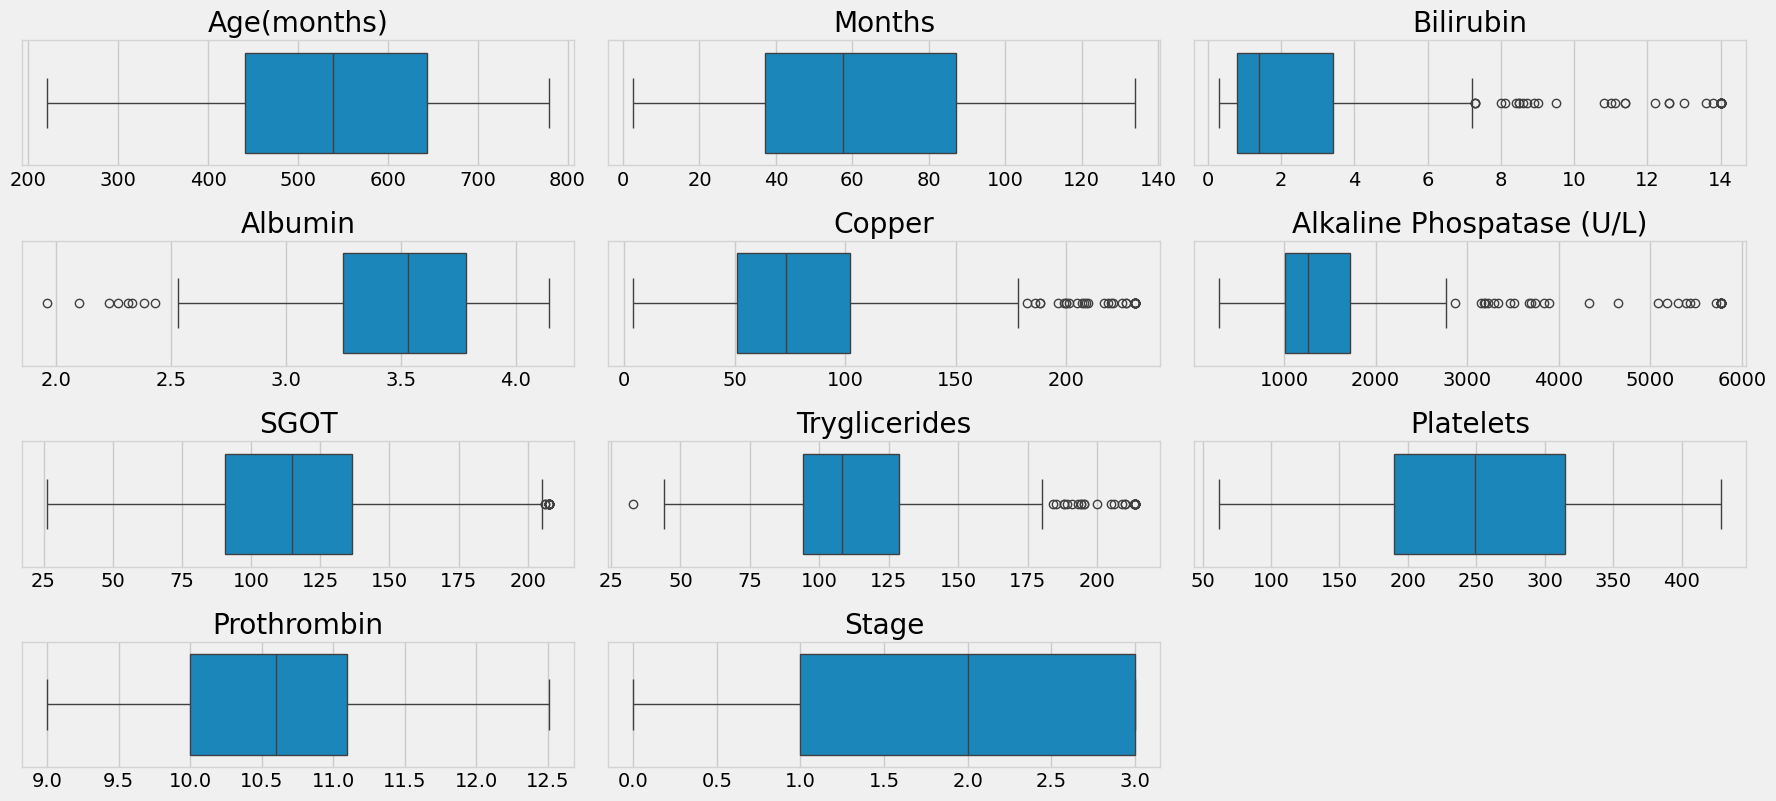

In [18]:
# Cleaning Outlier
for col in num_cols:
    upper_bound = df[col].quantile(0.95)
    df[col] = df[col].apply(lambda x: upper_bound if x > upper_bound else x)
plt.figure(figsize=(18, 10))

# Adjust the number of rows and columns in the subplot
n_rows = 5
n_cols = 3

for i, col in enumerate(num_cols, 1):
    ax = plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=df[col], ax=ax)
    plt.title(col)
    plt.xlabel("")
    
    # Add border to the current subplot
    for spine in ax.spines.values():
        spine.set_edgecolor('lightgrey')
        spine.set_linewidth(1)

plt.tight_layout() 
plt.show()


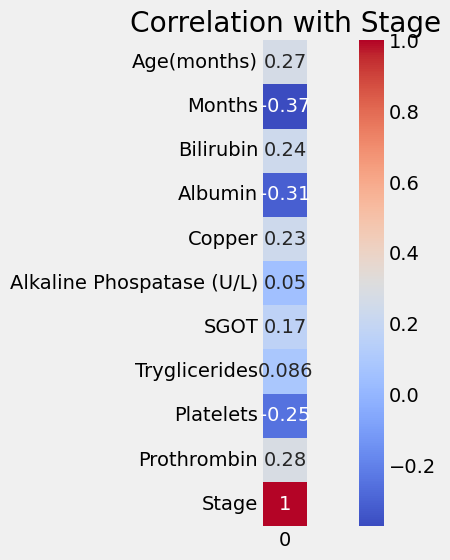

In [19]:
plt.figure(figsize=(12, 6))
sns.heatmap(df[num_cols].corrwith(df['Stage']).to_frame(), annot=True, cmap='coolwarm', square=True)
plt.title('Correlation with Stage')
plt.show()

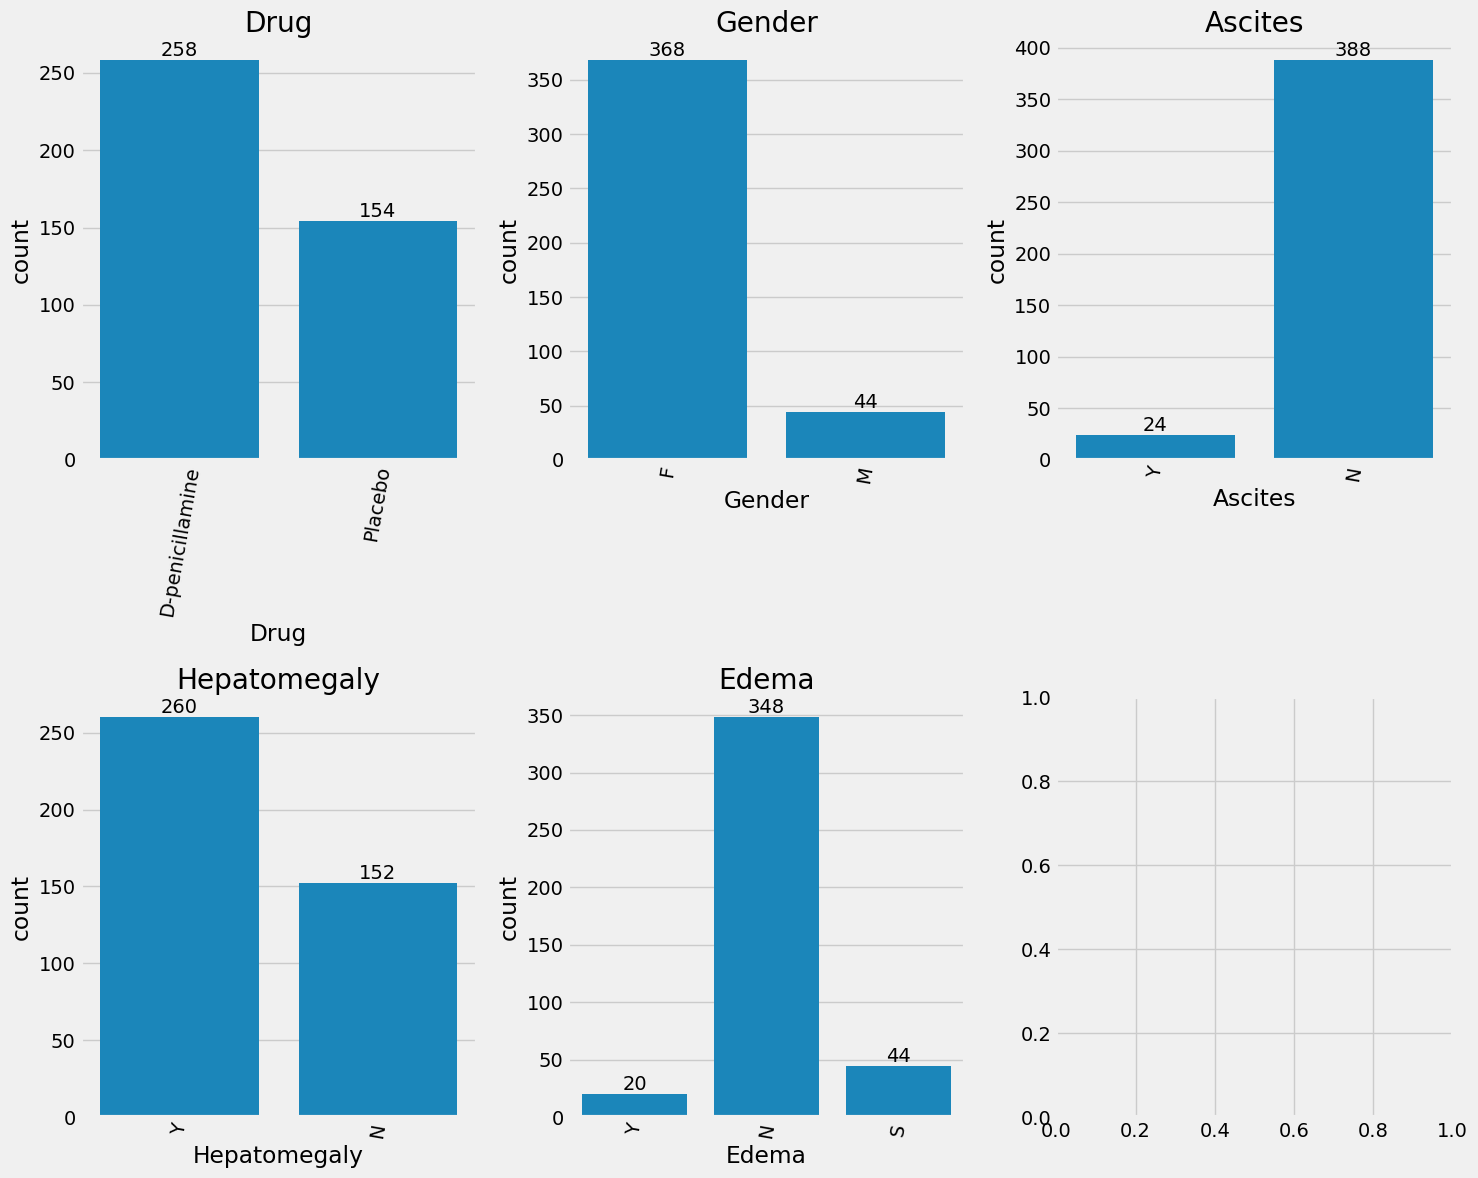

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(15, 12))

for i, col in enumerate(cat_cols):
    sns.countplot(x=col, data=df, ax=axs[i // 3, i % 3])
    axs[i // 3, i % 3].set_title(col)
    axs[i // 3, i % 3].tick_params(axis='x', rotation=80)
    for container in axs[i // 3, i % 3].containers:
        axs[i // 3, i % 3].bar_label(container)
plt.tight_layout()  # Ensure layout fits
plt.show()

some of this plot might be not accurate due to imputation

In [21]:
ord_enc = OrdinalEncoder(categories=[['N', 'S', 'Y']])

encoder = LabelEncoder()
for col in df.columns:
	if df[col].dtype=="O":
		df[col]= encoder.fit_transform(df[col])
del(encoder)

df.head()

,Age(months),Months,Drug,Gender,Ascites,Hepatomegaly,Edema,Bilirubin,Albumin,Copper,Alkaline Phospatase (U/L),SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,691.9800,14.4500,0,0,1,1,2,14.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,3
1,529.4700,133.8735,0,0,0,1,0,1.1,4.14,54.0,5770.3,113.52,88.0,221.0,10.6,2
2,779.4155,34.5600,0,1,0,0,1,1.4,3.48,210.0,516.0,96.10,55.0,151.0,12.0,3
3,593.5900,64.5500,0,0,0,1,1,1.8,2.54,64.0,5770.3,60.63,92.0,183.0,10.3,3
4,407.8200,50.7200,1,0,0,1,0,3.4,3.53,143.0,671.0,113.15,72.0,136.0,10.9,2


## 5. Model Development
In this section, machine learning models are developed and evaluated.

In [22]:
# Prepare features and target
X = df.drop('Stage', axis=1)
y = df['Stage']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(
	f'X_train shape: {X_train.shape}\n'+
	f'y_train shape: {y_train.shape}\n'+
	f'X_test shape:  {X_test.shape}\n'+
	f'y_test shape:  {y_test.shape}'
)

# Init model
rf= RandomForestClassifier()
xc= XGBClassifier()

X_train shape: (329, 15)
y_train shape: (329,)
X_test shape:  (83, 15)
y_test shape:  (83,)


Model: RandomForestClassifier
Accuracy: 0.4578
F1 Score (Weighted): 0.4412
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.31      0.28      0.29        18
           2       0.39      0.54      0.45        28
           3       0.62      0.58      0.60        31

    accuracy                           0.46        83
   macro avg       0.33      0.35      0.34        83
weighted avg       0.43      0.46      0.44        83




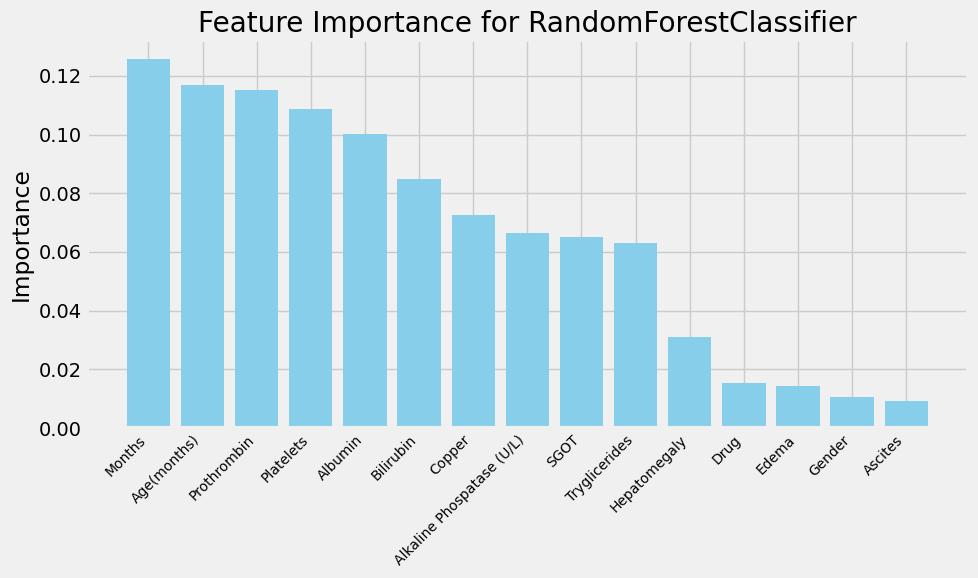

Model: XGBClassifier
Accuracy: 0.5181
F1 Score (Weighted): 0.5038
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.17      0.25         6
           1       0.27      0.22      0.24        18
           2       0.52      0.61      0.56        28
           3       0.64      0.68      0.66        31

    accuracy                           0.52        83
   macro avg       0.48      0.42      0.43        83
weighted avg       0.51      0.52      0.50        83




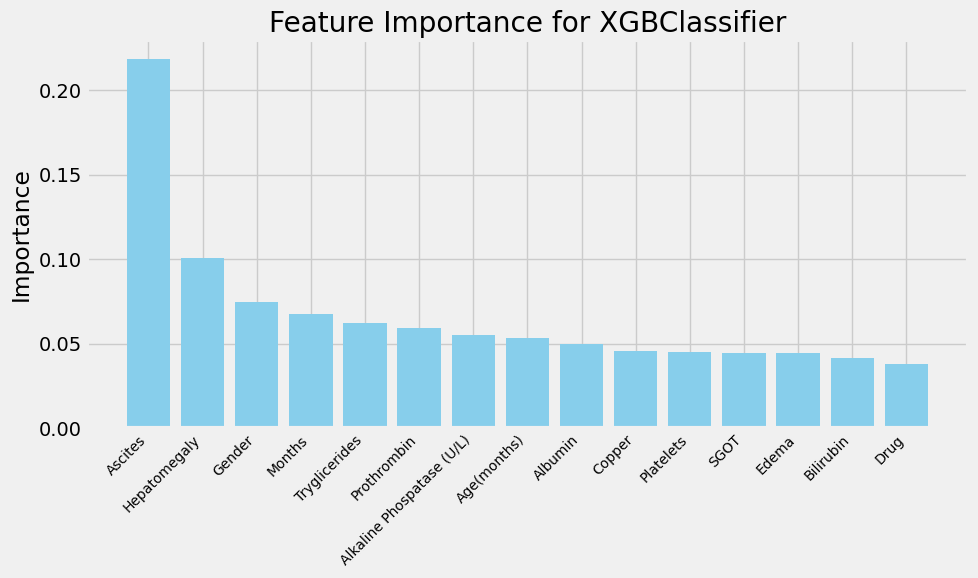

In [23]:
# Model Evaluation
def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions on the test set
    y_test_pred = model.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred, average='weighted')
    classification = classification_report(y_test, y_test_pred, zero_division=0)

    # Display evaluation metrics
    print(f"Model: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (Weighted): {f1:.4f}")
    print(f"Classification Report:\n{classification}\n")

    # Plot feature importance (if available)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        feature_names = X_train.columns  # Assuming X_train is a pandas DataFrame
        
        # Create the plot
        plt.figure(figsize=(10, 6))
        plt.title(f"Feature Importance for {model.__class__.__name__}")
        plt.bar(range(len(importances)), importances[indices], align="center", color="skyblue")
        plt.xticks(range(len(importances)), np.array(feature_names)[indices], rotation=45, ha='right', fontsize=10)
        plt.ylabel("Importance")
        plt.tight_layout()
        plt.show()
    else:
        print(f"The model {model.__class__.__name__} does not provide feature importances.\n")


# Evaluate Random Forest
evaluate_model(rf, X_train, y_train, X_test, y_test)

# Evaluate XGBoost
evaluate_model(xc, X_train, y_train, X_test, y_test)


In [24]:
# Hyperparameter Tuning for RandomForestClassifier
rf_param_grid = {
    'n_estimators': [50, 100, 150], # number of decision tree
    'max_depth': [3, 5, 8], # max depth of each decision tree
    'max_features': [0.5, 'sqrt', 'log2'] # max number of features to consider at each split
}
rf_grid_search = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=5, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)
print("Best parameters for RandomForest:", rf_grid_search.best_params_)


# Hyperparameter Tuning for XGBClassifier
xgb_param_grid = {
    'n_estimators': [50, 100, 150], # number of boosting rounds(tree)
    'max_depth': [3, 5, 8], # max depth of each tree
    'learning_rate': [0.01, 0.05, 0.1], # weight of each tree
}
xgb_grid_search = GridSearchCV(XGBClassifier(), xgb_param_grid, cv=5, scoring='accuracy')
xgb_grid_search.fit(X_train, y_train)
print("Best parameters for XGBoost:", xgb_grid_search.best_params_)

Best parameters for RandomForest: {'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 100}
Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}


Model: RandomForestClassifier
Accuracy: 0.4699
F1 Score (Weighted): 0.4416
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.38      0.17      0.23        18
           2       0.37      0.61      0.46        28
           3       0.66      0.61      0.63        31

    accuracy                           0.47        83
   macro avg       0.35      0.35      0.33        83
weighted avg       0.45      0.47      0.44        83




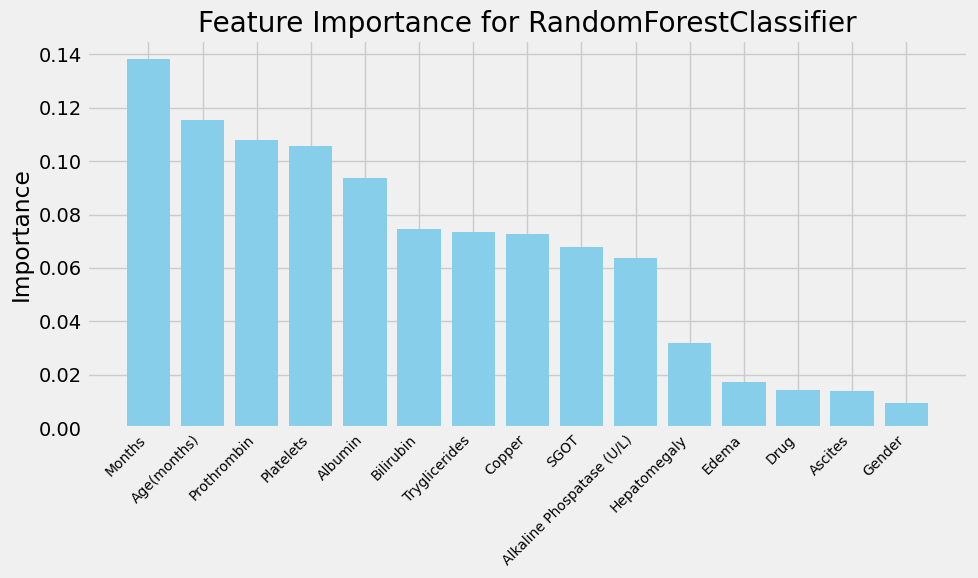

Model: XGBClassifier
Accuracy: 0.4940
F1 Score (Weighted): 0.4652
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.23      0.17      0.19        18
           2       0.50      0.64      0.56        28
           3       0.61      0.65      0.62        31

    accuracy                           0.49        83
   macro avg       0.33      0.36      0.35        83
weighted avg       0.45      0.49      0.47        83




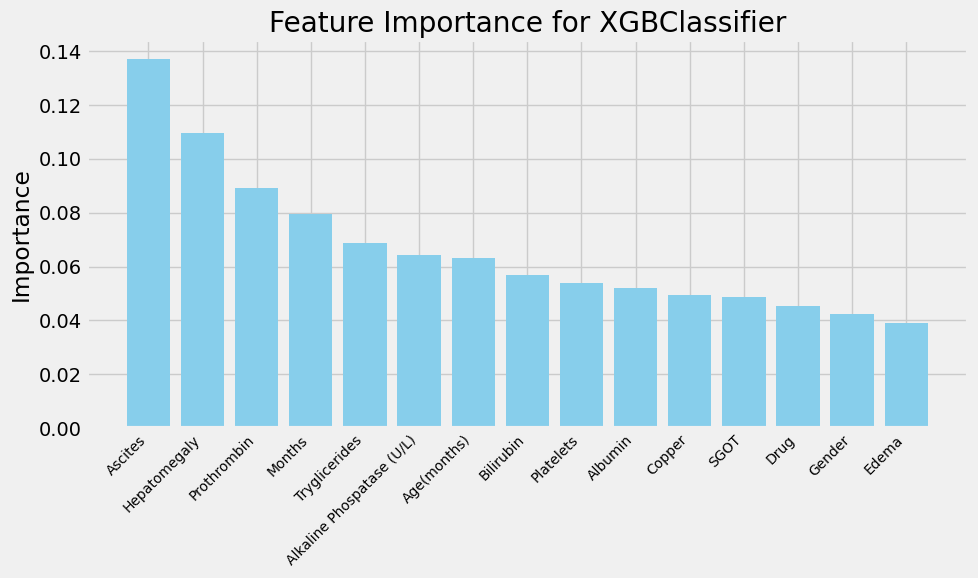

In [25]:
# Evaluate Best Models
evaluate_model(rf_grid_search.best_estimator_, X_train, y_train, X_test, y_test)
evaluate_model(xgb_grid_search.best_estimator_, X_train, y_train, X_test, y_test)

## Conclusion
The XGBClassifier performed slightly better than RandomForest, particularly in terms of overall accuracy and F1 Score. However, both models struggled with class imbalance, particularly for underrepresented classes.

This model could be improved by addressing values imbalance with acurate imputation or domain knowledge/expert